# Dataset Creation

- Using Vincent Van Gogh's artwork generate a series of paired images that are composed of a sketch and the true image.
- Add all data to a tensorflow dataset object and save.

### Setup

In [1]:
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
from random import shuffle
import pickle

In [2]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1

IMG_DIR ='./wikiart/wikiart-test/'
IMG_EXTENSIONS = ['.png', '.jpg', '.jpeg']

TRAINING_RATIO = 0.8

DATASET_SAVE_PATH = './Dataset'

### Load Images

Load images from directory which are horizontal and generate image paths.

Rotating an image in windows by right-clicking and using the 'rotate-left' and 'rotate-right' options do no change the orientation of the image according to PIL. This is due to EXIF tags and to obtain the correct result, edit the image itself in an image editor.

In [3]:
images_paths = set()
images_to_remove = set()

for ext in IMG_EXTENSIONS:
  images_paths = images_paths.union(Path(IMG_DIR).glob(f'**/*{ext}'))


for image_path in images_paths:
  image = Image.open(image_path)
  if image.size[0] < image.size[1]:
    images_to_remove.add(image_path)


images_paths.difference_update(images_to_remove)
images_paths = [str(image_path) for image_path in images_paths]


In [4]:
for image_path in images_paths:
    print(image_path)

wikiart\wikiart-test\images\vincent-van-gogh\1888\the-starry-night.jpg!Large.jpg
wikiart\wikiart-test\images\vincent-van-gogh\1885\the-green-wheatfield-behind-the-asylum-1889.jpg!Large.jpg
wikiart\wikiart-test\images\vincent-van-gogh\1887\the-reaper-1889.jpg!Large.jpg
wikiart\wikiart-test\images\vincent-van-gogh\1886\the-ravine-of-the-peyroulets-1889.jpg!Large.jpg


In [5]:
num_training = round(len(images_paths) * TRAINING_RATIO)
num_testing = len(images_paths) - num_training

shuffle(images_paths)

training_images = images_paths[:num_training]
testing_images = images_paths[num_training:]

In [6]:
print(f'Number of images in training: {len(training_images)}')
print(f'Number of images in testing: {len(testing_images)}')
print(f'Total number of images: {len(images_paths)}, Sum adds properly: {len(training_images) + len(testing_images) == len(images_paths)}')

Number of images in training: 3
Number of images in testing: 1
Total number of images: 4, Sum adds properly: True


Open a sample image.

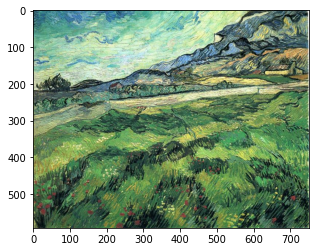

In [7]:
sample_image = tf.io.read_file((images_paths[0]))
sample_image = tf.io.decode_jpeg(sample_image)

plt.imshow(sample_image)

### Convert Images to Sketches

Using OpenCV convert image to grayscale, invert it and divide by inverted gaussian blur to get sketch like effect. This function must be executed as a tf.py_function.

In [21]:
def image_to_sketch(image):

   grey_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   invert = cv2.bitwise_not(grey_img)

   blur = cv2.GaussianBlur(invert, (21, 21), 0)
   invertedblur = cv2.bitwise_not(blur)
   sketch = cv2.divide(grey_img, invertedblur, scale=256.0)

   sketch = cv2.cvtColor(sketch, cv2.COLOR_GRAY2BGR)

   return sketch


### Stitch Sketch to Regular Image

In [30]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

stiched_images_paths = []

for image_path in images_paths:

    index = images_paths[0].rfind('.')
    stiched_file_name = images_paths[0][:index] + '-stiched' + images_paths[0][index:]
    stiched_images_paths.append(stiched_file_name)
    
    if cv2.imread(stiched_file_name) is not None:
        continue
    
    image = cv2.imread(image_path)
    sketch = image_to_sketch(image)
    
    concatenated_image = np.hstack((image, sketch))

    cv2.imwrite(stiched_file_name, concatenated_image)

### PIX2PIX Preprocessing

- Resize each 256 x 256 image to a larger height and width - 286 x 286.
- Randomly crop it back to 256 x 256.
- Randomly flip the image horizontally i.e. left to right (random mirroring).
- Normalize the images to the [-1, 1] range.

In [31]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [32]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [33]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [34]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [35]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [36]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [37]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

### Testing Pipeline for Single Image

This is for a single image where the sketch is generated and both images are sent via PIX2PIX preprocessing steps.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


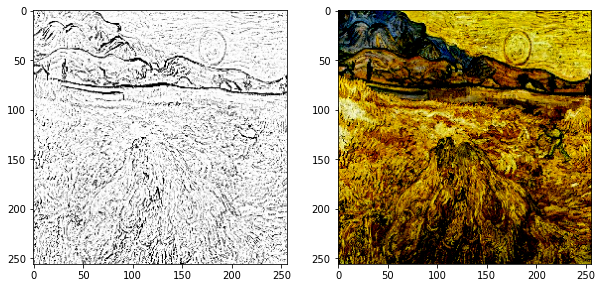

In [38]:
plt.figure(figsize=(10, 10))
input_image, real_image = load_image_train(stiched_images_paths[0])
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(real_image)

plt.show()


### Building the Pipeline

In [39]:
train_dataset = tf.data.Dataset.from_tensor_slices(stiched_images_paths)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [40]:
try:
  test_dataset = tf.data.Dataset.list_files(stiched_images_paths)
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(stiched_images_paths)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Saving the Dataset

In [52]:
from os import mkdir

directories = [DATASET_SAVE_PATH, DATASET_SAVE_PATH + '/train', DATASET_SAVE_PATH + '/test']

for directory in directories:
    try:
        mkdir(directory)
    except FileExistsError:
        print('Directory already exists')
        pass 
    except Exception as e:
        print(e)

Directory already exists
Directory already exists
Directory already exists


In [53]:
tf.data.experimental.save(
    train_dataset, DATASET_SAVE_PATH + '/train', compression='GZIP'
)
with open(DATASET_SAVE_PATH + '/train' + '/element_spec', 'wb') as out_:  # also save the element_spec to disk for future loading
    pickle.dump(train_dataset.element_spec, out_)
    

tf.data.experimental.save(
    test_dataset, DATASET_SAVE_PATH + '/test', compression='GZIP'
)
with open(DATASET_SAVE_PATH + '/test' + '/element_spec', 'wb') as out_:  # also save the element_spec to disk for future loading
    pickle.dump(test_dataset.element_spec, out_)

### Loading the Dataset

In [54]:
with open(DATASET_SAVE_PATH + '/train' + '/element_spec', 'rb') as in_:
    es = pickle.load(in_)

loaded_train_dataset = tf.data.experimental.load(
    DATASET_SAVE_PATH + '/train', es, compression='GZIP'
)


with open(DATASET_SAVE_PATH + '/test' + '/element_spec', 'rb') as in_:
    es = pickle.load(in_)

loaded_test_dataset = tf.data.experimental.load(
    DATASET_SAVE_PATH + '/test', es, compression='GZIP'
)

### Testing the Integrity of the Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


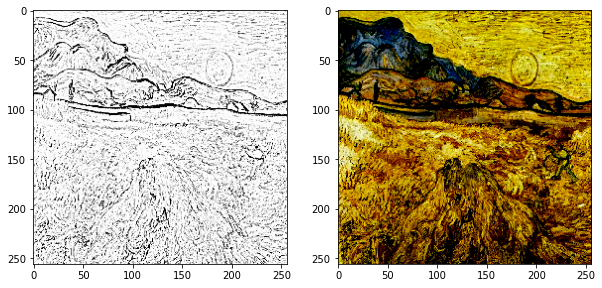

In [55]:
for item in loaded_train_dataset.take(1):
    input_image, real_image = item
    input_image = np.squeeze(input_image)
    real_image = np.squeeze(real_image)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(input_image, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(real_image)

    plt.show()